# Comparison of Structure Predictions Based on Data Format

In [1]:
import numpy as np
from diurnal import database, family, structure, train, utils, transform, visualize

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-05-26T22:07:37.606607 > INFO Download and install an RNA database.
2024-05-26T22:07:37.636807 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-05-26T22:07:37.639746 > INFO Extract the filenames from the directory `./data/archiveII/`.
2024-05-26T22:07:44.392121 >    0 / 3975 [                                                  ] 16s_A.fulgidus.ct>    1 / 3975 [                                                  ] 16s_A.fulgidus_domain1.ct>    2 / 3975 [                                                  ] 16s_A.fulgidus_domain2.ct>    3 / 3975 [                                                  ] 16s_A.fulgidus_domain3.ct>    4 / 3975 [                                                  ] 16s_A.fulgidus_domain4.ct>    5 / 3975 [                                                  ] 16s_A.pyrophilus.ct>    6 / 3975 [                                                  ] 16s_A.pyrophilus_domain1.ct>    7 / 3975 [                                                  ] 16s_

In [3]:
def collapse(primary, secondary, size):
    potential_pairings = structure.Primary.to_matrix(
        primary, size, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    potential_pairings = transform.linearize_half_matrix(
        potential_pairings, len(primary), N=128**2
    )
    potential_pairings = transform.collapse_linearized_matrix(
        potential_pairings, N=128**2
    )
    #print(len(potential_pairings))
    contact = structure.Secondary.to_matrix(secondary)
    contact = transform.linearize_half_matrix(contact, len(primary), N=128**2)
    #print(len(contact))
    contact = transform.collapse_like(potential_pairings, contact)
    return potential_pairings, contact

In [4]:
_, primary, secondary = utils.rna_data.read_ct_file(train_names[0])
a, b = collapse(primary, secondary, 128)

In [5]:
originals = []
compressed = []
for name in train_names:
    _, primary, secondary = utils.rna_data.read_ct_file(name)
    originals.append(len(primary))
    a, b = collapse(primary, secondary, 128)
    compressed.append(len(a))

A = np.array(originals)
B = np.array(compressed)
print(f"Min: {A.min()}    {B.min()}")
print(f"Avr: {A.mean()}    {B.mean()}")
print(f"Max: {A.max()}    {B.max()}")
rate = B / (A**2 / 2)
print(f"Min: {rate.min()}")
print(f"Avr: {rate.mean()}")
print(f"Max: {rate.max()}")

Min: 28    16384
Avr: 103.03387096774193    16384.0
Max: 128    16384
Min: 2.0
Avr: 3.757914376955017
Max: 41.795918367346935


In [6]:
def format(dst: str, names: list[str]):
    # Primary structures
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_onehot.npy",
        SIZE, structure.Primary.to_matrix
    )
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    database.format_primary_structure(
        names, f"{dst}primary_collapsed.npy",
        SIZE, transform.primary_collapse_formatter
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_bracket.npy", SIZE,
        structure.Secondary.to_onehot, verbosity=0
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix, verbosity=0
    )
    distance_formatter = lambda x, y: structure.Secondary.to_distance_matrix(
        x, y, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance.npy", SIZE, distance_formatter,
        verbosity=0
    )
    database.format_primary_secondary_structure(
        names, f"{dst}secondary_collapsed.npy", SIZE,
        transform.secondary_collapse_formatter, verbosity=0
    )
    distance_formatter = lambda x, y, size: transform.secondary_collapse_formatter(
        x, y, size, power=5
    )
    database.format_primary_secondary_structure(
        names, f"{dst}secondary_collapsed_distance.npy", SIZE,
        distance_formatter, verbosity=0
    )

In [7]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-05-26T22:08:06.171135 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy`.
2024-05-26T22:08:06.194940 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy` already contains the formatted data.
2024-05-26T22:08:06.197131 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-05-26T22:08:06.202667 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-05-26T22:08:06.204529 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-05-26T22:08:06.239421 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-05-26T22:08:06.242087 > INFO Formatting primary structures into `./data/archiveII_processed_128/

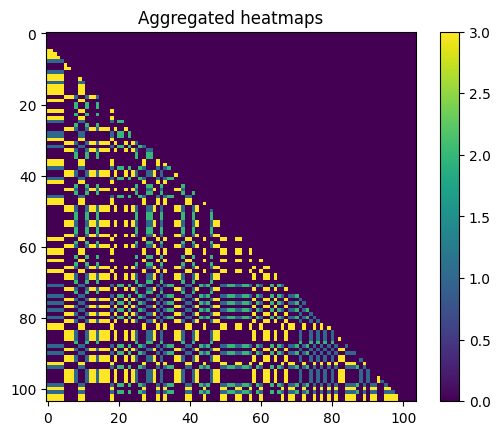

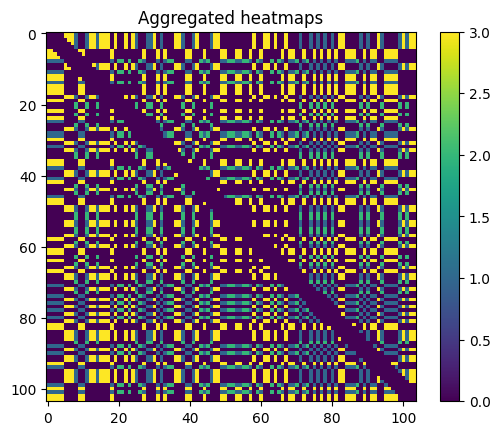

In [23]:
index = 0

primary = np.load(f"{DST}train/primary_onehot.npy")
sequence = structure.Primary.to_sequence(primary[index])
original_length = len(sequence)
collapsed_primary = np.load(f"{DST}train/primary_collapsed.npy")
potential_pairings = transform.decollapse_linearized_matrix(
    collapsed_primary[index], N_output=128**2
)
potential_pairings = transform.delinearize_half_matrix(potential_pairings, original_length)
visualize.heatmap(potential_pairings)

probe = structure.Primary.to_matrix(sequence, map=structure.Schemes.IUPAC_PAIRINGS_SCALARS)
visualize.heatmap(probe)